In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# os.environ['FOUNDATION_SAVE_DIR'] = r'D:\completed'
# os.environ['FOUNDATION_DATA_DIR'] = r'D:\local_data'
# os.environ['FOUNDATION_SAVE_DIR'] = r'F:\completed'
# os.environ['FOUNDATION_DATA_DIR'] = r'F:\local_data'
# os.environ['FOUNDATION_SAVE_DIR'] = r'C:\Users\anwan\Documents\workspace\celeb'
# os.environ['FOUNDATION_SAVE_DIR'] = r'C:\Users\anwan\Documents\workspace\sep_trained_nets'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

import omnifig as fig

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
# from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib import cm
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

from tabulate import tabulate

import visualizations as viz_util
import project as proj
# import pointnets as ptn

%matplotlib notebook

np.set_printoptions(linewidth=120)
fig.initialize()

In [2]:

# SMALL_SIZE = 14
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 18

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:

def save_fig(name):
    plt.savefig(f'new_figures/{name}.png')
    plt.savefig(f'new_figures/{name}.pdf')
    print(name, 'saved')
    
def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

In [4]:
info = util.adict()
info.device = 'cuda'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {
    'Branch':'C0', 
          'Baseline':'C1', 
          'Conv':'C2', 
          'Attention':'C3',
        'Ladder': 'C4',
         }
info.tnames = {'Branch':'Structural', 'Baseline':'Baseline', 'Conv':'Simple', 'Attention':'Attention', 'Ladder': 'Ladder'}

info.ds = '3ds'

preset_figure_info(info)
print(info)

t{device, results_name, small_font_size, medium_font_size, large_font_size, colors, tnames, ds}


In [5]:
root = os.environ['FOUNDATION_SAVE_DIR']

root = r'C:\Users\anwan\Documents\workspace\sep_trained_nets'

root

'C:\\Users\\anwan\\Documents\\workspace\\sep_trained_nets'

In [22]:
run_names = {
#     'AE':'ae_3ds_200930-221727',
#     'Ada-In': 'ae_3ds_12b1-adain_200930-221124',
#     'SAE12': 'ae_3ds_12b1_200930-220945',
#     'VAE': 'vae_3ds_200930-221728',
#     '4VAE': 'vae_3ds_beta4_200930-225714',
    '16VAE': 'vae_3ds_beta16_200930-225714',
}
run_titles = {v:k for k,v in run_names.items()}
locs = list(run_names.values())
locs

['vae_3ds_beta16_200930-225714']

In [7]:
runs = [fig.quick_run('load-run', root=root, path=name, override={'output.saveroot': '<>root' })
        for name in locs]
run = runs[0]
len(runs)

| [Pushed] run._type: 'run'
| CREATING run (type=run)
|  > records: {} (by default)
|  > silent: False (by default)
|  > skip_run_load: False (by default)
|  > last: False (by default)
|  > load: None (by default)
|  > resume --> path: 'vae_3ds_beta16_200930-225714/'
|  > saveroot --> root: 'C:\\Users\\anwan\\Documents\\workspace\\sep_trained_nets'
|  > [Pushed] novel: False
|  > override [dict with 1 item/s]
|  >  > (output): output [dict with 1 item/s]
|  >  >  > (saveroot): saveroot --> ..root: 'C:\\Users\\anwan\\Documents\\workspace\\sep_trained_nets'
|  > extend: None (by default)
Loading Config: vae_3ds_beta16_200930-225714/
|  > [Pushed] model._load_params: 'C:\\Users\\anwan\\Documents\\workspace\\sep_trained_nets\\vae_3ds_beta16_200930-225714\\ckpt-model_100000.pth.tar'
|  > .name: 'vae_3ds_beta16'
|  > invisible: False (by default)
|  > logdate: True (by default)
|  > [Pushed] output.save_dir: 'vae_3ds_beta16_200930-225714'
|  > output.saveroot: 'C:\\Users\\anwan\\Documents\\w

1

In [8]:
for run in runs:
    model = run.get_model()
# print(model)
pass

| .seed: 0
| CREATING model (type=vae)
|  > CREATING encoder (type=conv) (mod=normal)
|  >  > .latent_dim: 12
|  >  > min_log_std: None (by default)
|  >  > in_shape --> ..din [list with 3 item/s]
|  >  >  > (0): 3
|  >  >  > (1): 64
|  >  >  > (2): 64
|  >  > latent_dim: 24
|  >  > feature_dim: None (by default)
|  >  > .nonlin: 'elu'
|  >  > output_nonlin: None (by default)
|  >  > residual: False (by default)
|  >  > channels [list with 5 item/s]
|  >  >  > (0): 32
|  >  >  > (1): 32
|  >  >  > (2): 64
|  >  >  > (3): 64
|  >  >  > (4): 128
|  >  > kernels: 3
|  >  > strides: 2
|  >  > factors: 1
|  >  > down: 'max'
|  >  > .norm: 'group'
|  >  > output_norm: None (by default)
|  >  > fc_hidden [list with 2 item/s]
|  >  >  > (0): 256
|  >  >  > (1): 128
|  > CREATING decoder (type=deconv)
|  >  > out_shape --> ..dout [list with 3 item/s]
|  >  >  > (0): 3
|  >  >  > (1): 64
|  >  >  > (2): 64
|  >  > .latent_dim: 12
|  >  > .nonlin: 'elu'
|  >  > output_nonlin: 'sigmoid'
|  >  > ch

In [9]:
with torch.no_grad():
    gen = model.generate(9)
util.show_imgs(gen)
pass

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


<IPython.core.display.Javascript object>

In [10]:
for run in runs:
    data = run.get_results('eval')
    run.eval_data = data
data.keys()

dict_keys(['out', 'stats', 'stats_num', 'hyb_fid_stats', 'hyb_fid', 'rec_fid_stats', 'rec_fid', 'prior_fid_stats', 'prior_fid'])

In [11]:
data['hyb_fid'], data['rec_fid']

(48.32825736511174, 42.69635038061023)

In [13]:
X = run.eval_data['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

In [23]:
run = runs[0]
model = run.get_model()
model.to(info.device)
run.title = run_titles[run.save_dir]
run.title, run.name

('16VAE', 'vae_3ds_beta16')

In [24]:
info.bidx = 0

In [25]:
# X = run[info.results_name]['out']['original']
with torch.no_grad():
    Q = model.encode(X.to(info.device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[info.bidx]
Q.shape, q.shape

(torch.Size([128, 12]), torch.Size([12]))

In [26]:
info.n = 16
info.steps = 20
info.steps = 7
# info.steps = 5
info.ntrav = 1
info.stretch = 0.1

In [27]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=info.steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-info.stretch*rg, Q.max(0)[0].unsqueeze(-1)+info.stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=info.device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

torch.Size([1, 12, 7, 3, 64, 64])

In [28]:
if 'ds' in info and info.ds == 'celeb':
    run.tH, run.tW = 16, 2
    run.tH, run.tW = 32, 1
run.tH, run.tW = 4,3
run.tH, run.tW = 12,1
run.tH, run.tW

(12, 1)

In [29]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, run.tH, run.tW, S, C, H, W)
# full = full.permute(0, 3, 4, 1, 5, 2, 6).contiguous().view(B, S, C, tH * H, tW * W)
full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

full.shape

torch.Size([12, 64, 448, 3])

In [30]:
def color_ax(c):
    ax.spines['bottom'].set_color(c)
    ax.spines['top'].set_color(c) 
    ax.spines['right'].set_color(c)
    ax.spines['left'].set_color(c)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.yaxis.label.set_color(c)
    ax.xaxis.label.set_color(c)
    ax.title.set_color(c)

In [31]:
cmap = cm.get_cmap('jet')

In [32]:
# highlight = [None]*12
# highlight = ['C1']*12

# highlight = [0,1,-1,2,3,-1,-1,4,-1,-1,-1,5]
# mh = max(info.highlight)
# hls = [(cmap(h/mh) if h >= 0 else 'k') for h in highlight]
# hls = [(f'C{h}' if h >= 0 else 'k') for h in info.highlight]
# len(hls), hls

<IPython.core.display.Javascript object>


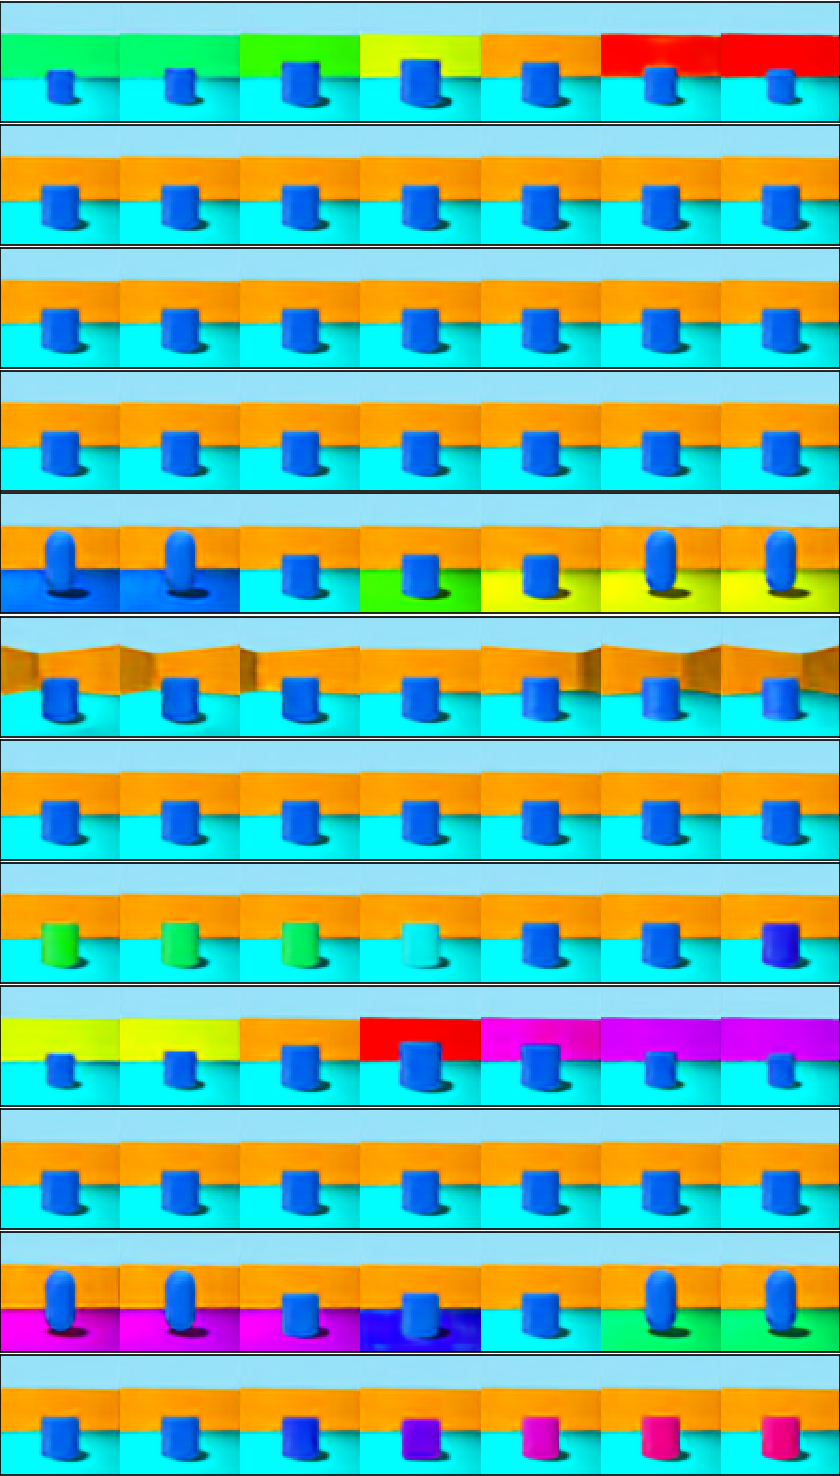

In [33]:
fg, axes = plt.subplots(run.tH,1, figsize=(info.steps*0.8,run.tH*run.tW*0.82))
for i,(ax, p) in enumerate(zip(axes,full)):
    plt.sca(ax)
    lw=3
#     ax.spines['bottom'].set_linewidth(lw)
#     ax.spines['top'].set_linewidth(lw) 
#     ax.spines['right'].set_linewidth(lw)
#     ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
border, between = 0.01, 0.02
border, between = 0.0, 0.0
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [34]:
save_fig(f'{info.ds}_{run.title}_walks')

3ds_16VAE_walks saved


In [43]:
W = model.dec.fc[0].weight.detach().pow(2)
W.sum(0)

tensor([17.8806,  0.0536,  0.0282,  0.0252, 18.8031,  9.2554,  0.2662, 12.9670,
        18.8894,  0.0242, 18.9678, 12.2187], device='cuda:0')

<IPython.core.display.Javascript object>


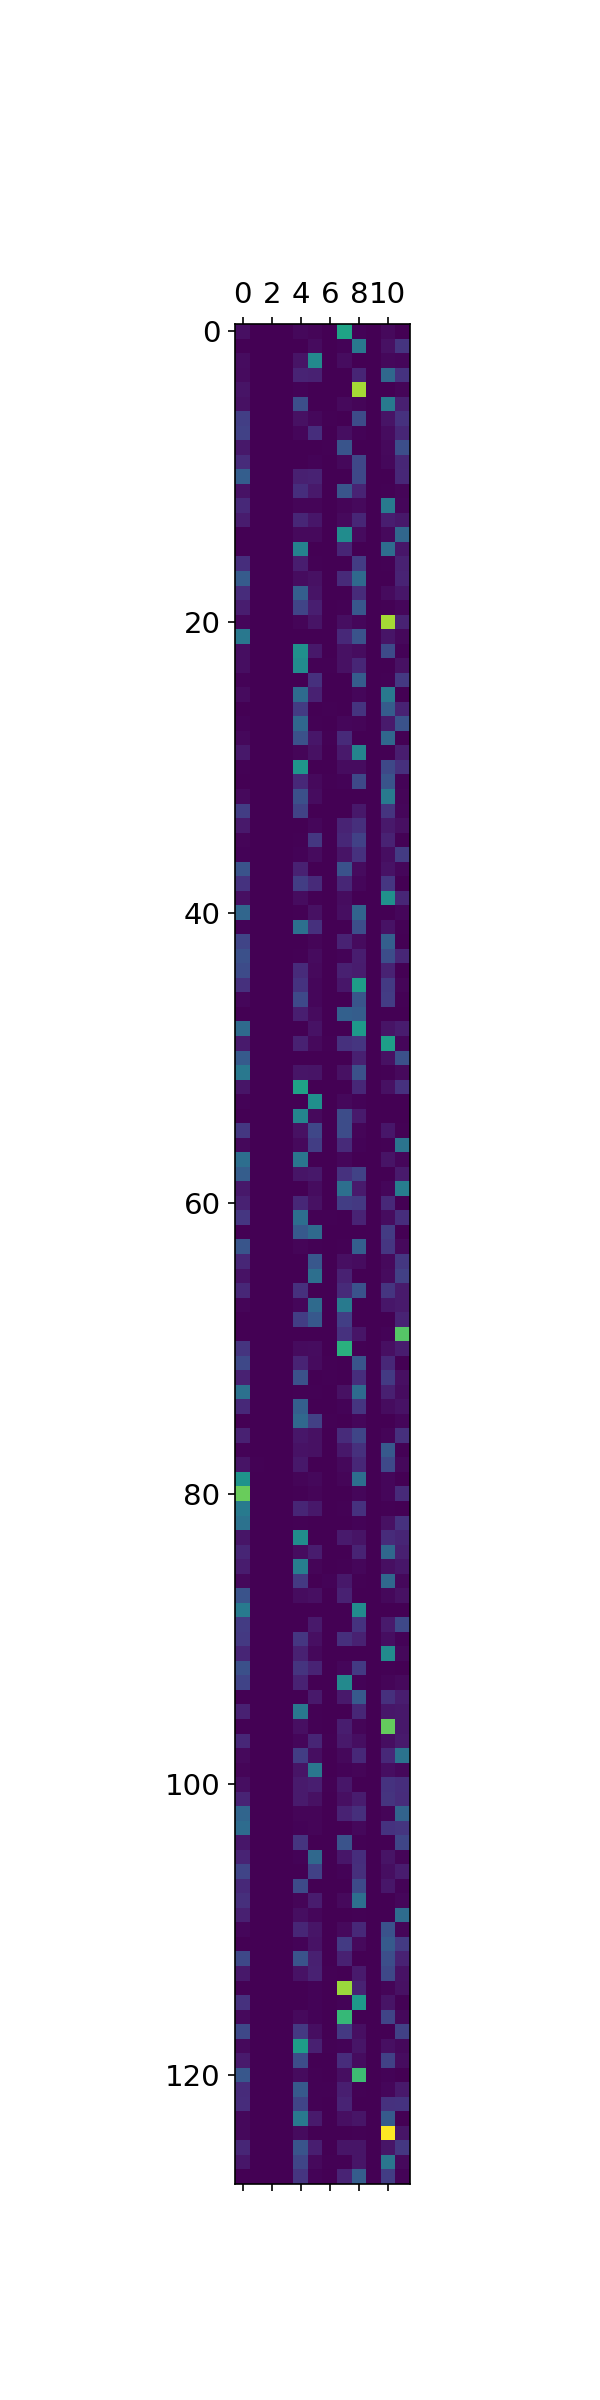

In [48]:
plt.matshow(W.cpu().numpy())
pass

In [2]:
def organize(raw, runs=None, **common):
    raw = raw.split('\n')
    if runs is None:
        runs = util.Table()
    for line in raw:
        n,t,r = line.split('\t')
        runs.new(name=n, arch=t, rname=r, **common)
    return runs

def save_fig(name):
    plt.savefig(f'talk_figures/{name}.png')
    plt.savefig(f'talk_figures/{name}.pdf')
    print(name, 'saved')
    
def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    
fixed_name_codes = {
    '12 Branch': 'K12',
    '6 Branch': 'K6',
    '4 Branch': 'K4',
    
    '12 Head': 'H12',
    '6 Head': 'H6',
    '4 Head': 'H4',
    
    '12 LVAE': 'L12',
    '6 LVAE': 'L6',
    '4 LVAE': 'L4',
}
fixed_names = {
    '12 Branch': '12-SAE',
    '6 Branch': '6-SAE',
    '4 Branch': '4-SAE',
    
    '12 Head': '12-ASAE',
    '6 Head': '6-ASAE',
    '4 Head': '4-ASAE',
    
    '12 LVAE': '12-VLAE',
    '6 LVAE': '6-VLAE',
    '4 LVAE': '4-VLAE',
}

def fix_names(run):
    
    if run.name in fixed_name_codes:
        run.code = fixed_name_codes[run.name]
    else:
        run.code = run.name
        
    if run.name in fixed_names:
        run.name = fixed_names[run.name]

def encode(model, X):
    with torch.no_grad():
        q = model.encode(X.cuda())
    if isinstance(q, distrib.Distribution):
        q = q.mean
    return q.cpu()

In [28]:
info = util.tdict()

In [29]:

info.device = 'cuda'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {
    'Branch':'C0', 
          'Baseline':'C1', 
          'Conv':'C2', 
          'Attention':'C3',
        'Ladder': 'C4',
         }
info.tnames = {'Branch':'Structural', 'Baseline':'Baseline', 'Conv':'Simple', 'Attention':'Attention', 'Ladder': 'Ladder'}

preset_figure_info(info)
print(info)

t{device, results_name, small_font_size, medium_font_size, large_font_size, colors, tnames}


In [30]:
model_names = [
    ('AE', 'Conv'),
    ('VAE', 'Conv'),
    ('4VAE', 'Conv'),
    ('16VAE', 'Conv'),
    ('WAE', 'Conv'),
    ('12 Branch', 'Branch'),
    ('6 Branch', 'Branch'),
    ('4 Branch', 'Branch'),
    ('12 Head', 'Attention'),
    ('6 Head', 'Attention'),
    ('4 Head', 'Attention'),
    ('4 LVAE', 'Ladder'),
    ('6 LVAE', 'Ladder'),
    ('12 LVAE', 'Ladder'),
    ('AE', 'Baseline'),
    ('VAE', 'Baseline'),
    ('4VAE', 'Baseline'),
    ('16VAE', 'Baseline'),
    ('WAE', 'Baseline'),
]
len(model_names)

19

In [31]:
raw = '''AE	Conv	3ds-ae-conv_0002-6337051-00_200508-232722
AE-L2	Conv	3ds-ae-b1-conv_0002-6337051-01_200508-232718
VAE	Conv	3ds-vae-b1-conv_0002-6337051-03_200508-232715
2VAE	Conv	3ds-vae-b2-conv_0002-6337051-04_200508-232711
4VAE	Conv	3ds-vae-b4-conv_0002-6337051-05_200508-232713
8VAE	Conv	3ds-vae-b8-conv_0002-6337051-06_200508-232748
16VAE	Conv	3ds-vae-b16-conv_0002-6337051-07_200508-232723
32VAE	Conv	3ds-vae-b32-conv_0002-6337051-08_200508-232717
WAE	Conv	3ds-wae-conv_0002-6337051-02_200508-232718
12 Branch	Branch	3ds-ae-12b1-conv_0005-6337809-01_200509-120419
6 Branch	Branch	3ds-ae-6b2-conv_0034-6373616-01_200518-163704
4 Branch	Branch	3ds-ae-4b3-conv_0034-6373616-00_200518-163709
12 Head	Attention	3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612
6 Head	Attention	3ds-ae-12b1-6h1k32v32_0001-6337050-08_200508-232652
4 Head	Attention	3ds-ae-12b1-4h1k32v32_0001-6337050-07_200508-232614
12 LVAE	Ladder	3ds-vae-lddrev12_0042-6464006-07_200522-152910
12 Ladder-AE	Ladder	3ds-ae-lddrev12_0042-6464006-04_200522-152948
6 LVAE	Ladder	3ds-vae-lddrev6_0042-6464006-06_200522-152917
6 Ladder-AE	Ladder	3ds-ae-lddrev6_0042-6464006-03_200522-152912
4 LVAE	Ladder	3ds-vae-lddrev4_0042-6464006-05_200522-152911
4 Ladder-AE	Ladder	3ds-ae-lddrev4_0042-6464006-02_200522-152915
AE	Baseline	3ds-ae-dislib_0003-6337807-00_200509-120112
AE-L2	Baseline	3ds-ae-b1-dislib_0003-6337807-01_200509-120113
VAE	Baseline	3ds-vae-b1-dislib_0003-6337807-03_200509-120115
2VAE	Baseline	3ds-vae-b2-dislib_0003-6337807-04_200509-120115
4VAE	Baseline	3ds-vae-b4-dislib_0003-6337807-05_200509-120125
8VAE	Baseline	3ds-vae-b8-dislib_0003-6337807-06_200509-120109
16VAE	Baseline	3ds-vae-b16-dislib_0003-6337807-07_200509-120113
32VAE	Baseline	3ds-vae-b32-dislib_0003-6337807-08_200509-120119
WAE	Baseline	3ds-wae-dislib_0003-6337807-02_200509-120136'''



info.ds = '3ds'
info.fsize = (6,4)
info.fsize = (9,6)
info.title = '3D-Shapes'

info.bidx = 9
# info.bidx = 2
# info.highlight = [-1,0,-1,1,2,-1,3,3,4,4,5,5,]

In [14]:
raw = '''AE	Conv	mpi3d-ae-conv_0011-6341579-00_200511-035009
AE-L2	Conv	mpi3d-ae-b1-conv_0011-6341579-01_200511-035004
VAE	Conv	mpi3d-vae-b1-conv_0011-6341579-03_200511-035007
2VAE	Conv	mpi3d-vae-b2-conv_0011-6341579-04_200511-035008
4VAE	Conv	mpi3d-vae-b4-conv_0011-6341579-05_200511-035016
8VAE	Conv	mpi3d-vae-b8-conv_0011-6341579-06_200511-035007
16VAE	Conv	mpi3d-vae-b16-conv_0011-6341579-07_200511-035003
32VAE	Conv	
WAE	Conv	mpi3d-wae-conv_0011-6341579-02_200511-035010
12 Branch	Branch	mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023
6 Branch	Branch	mpi3d-ae-toy-6b2_0056-6468034-01_200525-033418
4 Branch	Branch	mpi3d-ae-toy-4b3-conv_0071-6472326-00_200526-191939
12 Head	Attention	mpi3d-ae-12b1-12h1k32v32_0013-6343740-04_200512-014614
6 Head	Attention	mpi3d-ae-12b1-6h1k32v32_0013-6343740-08_200512-014603
4 Head	Attention	mpi3d-ae-12b1-4h1k32v32_0013-6343740-07_200512-014605
12 LVAE	Ladder	mpi3d-vae-lddrev12_0042-6464006-13_200522-152922
12 Ladder-AE	Ladder	mpi3d-ae-lddrev12_0042-6464006-10_200522-152920
6 LVAE	Ladder	mpi3d-vae-toy-lddrev6_0071-6472326-01_200526-191942
6 Ladder-AE	Ladder	mpi3d-ae-lddrev6_0042-6464006-09_200522-152920
4 LVAE	Ladder	mpi3d-vae-lddrev4_0042-6464006-11_200522-152927
4 Ladder-AE	Ladder	mpi3d-ae-lddrev4_0042-6464006-08_200522-152926'''

if ('16VAE', 'Conv') in model_names:
    model_names.remove(('16VAE', 'Conv'))

info.ds = 'toy'
info.fsize = (6,4)
info.fsize = (9,6)
info.title= 'MPI3D Toy'
info.bidx = 13 #24
info.bidx = 51
# info.highlight = [0,0,0,1,2,3,4,4,5,-1,6,5,] # toy
info.ridx = 2
info.baselines = {}


In [15]:
raw = '''AE	Conv	mpi3d-ae-conv_0012-6341580-00_200511-035101
AE-L2	Conv	mpi3d-ae-b1-conv_0012-6341580-01_200511-035039
VAE	Conv	mpi3d-vae-b1-conv_0012-6341580-03_200511-035054
2VAE	Conv	mpi3d-vae-b2-conv_0012-6341580-04_200511-035041
4VAE	Conv	mpi3d-vae-b4-conv_0012-6341580-05_200511-035040
8VAE	Conv	mpi3d-vae-b8-conv_0012-6341580-06_200511-035042
16VAE	Conv	mpi3d-vae-b16-conv_0012-6341580-07_200511-035036
32VAE	Conv	
WAE	Conv	mpi3d-wae-conv_0012-6341580-02_200511-035101
12 Branch	Branch	mpi3d-ae-12b1-conv_0012-6341580-09_200511-035033
6 Branch	Branch	mpi3d-ae-real-6b2_0056-6468034-03_200525-033420
4 Branch	Branch	mpi3d-ae-real-4b3_0056-6468034-02_200525-033422
12 Head	Attention	mpi3d-ae-12b1-12h1k32v32_0015-6346974-04_200513-020758
6 Head	Attention	mpi3d-ae-12b1-6h1k32v32_0015-6346974-08_200513-020756
4 Head	Attention	mpi3d-ae-12b1-4h1k32v32_0015-6346974-07_200513-020753
12 LVAE	Ladder	mpi3d-vae-real-lddrev12_0048-6464516-02_200522-212011
12 Ladder-AE	Ladder	mpi3d-ae-real-lddrev12-s2_0071-6472326-07_200526-191933
6 LVAE	Ladder	mpi3d-vae-real-lddrev6_0048-6464516-01_200522-212003
6 Ladder-AE	Ladder	mpi3d-ae-real-lddrev6_0071-6472326-03_200526-191932
4 LVAE	Ladder	mpi3d-vae-real-lddrev4_0048-6464516-00_200522-212001
4 Ladder-AE	Ladder	mpi3d-ae-real-lddrev4_0071-6472326-04_200526-191934'''

if ('16VAE', 'Conv') in model_names:
    model_names.remove(('16VAE', 'Conv'))

info.ds = 'real'
info.fsize = (6,4)
info.fsize = (9,6)
info.title= 'MPI3D Real'
info.bidx = 24 #48
info.bidx = 13
info.bidx = 36
# info.highlight = [0,1,0,1,0,2,-1,3,4,5,5,-1]
info.ridx = 2
info.baselines = {}


In [16]:
raw = '''AE	Conv	celeba-ae-conv_0031-6362398-02_200517-170621
WAE	Conv	celeba-wae_0055-6465665-00_200524-143155
VAE	Conv	celeba-vae-b1-conv_0031-6362398-04_200517-170613
2VAE	Conv	celeba-vae-b2-conv_0031-6362398-01_200517-170616
2VAE	Conv	celeba-vae-b2-conv-s2_0031-6362398-08_200517-170614
4VAE	Conv	celeba-vae-b4-conv_0031-6362398-05_200517-170611
16VAE	Conv	celeba-vae-b16-conv_0031-6362398-06_200517-170622
16-SAE	Branch	celeba-ae-12b1-conv_0031-6362398-00_200517-170612
16-SAE	Branch	celeba-ae-12b1-conv-s2_0031-6362398-07_200517-170615
16-ASAE	Attention	celeba-ae-12b1-12h_0080-6474327-00_200527-164855
16-SVAE	Branch	celeba-vae-12b1_0080-6474327-03_200527-164858
16-ASAE	Attention	celeba-ae-12b1-12h-s2_0080-6474327-01_200527-164901
16-ASVAE	Attention	celeba-vae-12b1-12h_0080-6474327-02_200527-164903'''

raw = '''AE	Conv	celeba-ae-conv_0031-6362398-02_200517-170621
WAE	Conv	celeba-wae_0055-6465665-00_200524-143155
VAE	Conv	celeba-vae-b1-conv_0031-6362398-04_200517-170613
2VAE	Conv	celeba-vae-b2-conv_0031-6362398-01_200517-170616
4VAE	Conv	celeba-vae-b4-conv_0031-6362398-05_200517-170611
16VAE	Conv	celeba-vae-b16-conv_0031-6362398-06_200517-170622
16-SAE	Branch	celeba-ae-12b1-conv-s2_0031-6362398-07_200517-170615
16-ASAE	Attention	celeba-ae-12b1-12h_0080-6474327-00_200527-164855'''


info.ds = 'celeb'
info.fsize = (6,4)
info.title= 'Celeb-A'
info.device = 'cpu'
info.bidx = 24 #48
info.bidx = 8
# info.highlight = [0,1,0,1,0,2,-1,3,4,5,5,-1]
info.ridx = 2
info.baselines = {}

In [22]:
runs = organize(raw, dataset=info.ds)
if info.ds != 'celeb':
    runs.filter_(lambda r: (r.name, r.arch) in model_names)
# runs.filter_(lambda r: r.arch == 'Attention')

runs.map(fix_names)
len(runs)

18

In [23]:
# runs[5].rname = '3ds-ae-12b1_0052-6286534-00_200429-030431'

In [32]:
def load_model(run):
    if 'model' not in run:
        A = trn.get_config()
        A.din = (3, 128,128) if info.ds == 'celeb' else (3, 64, 64)
        A.dout = A.din

        model, = trn.load(run.rname, config=A, get_data=None, update_config=True) # for loading only the model
        model.to(info.device)
        run.model = model
    
def load_data(run):
    rname = run.rname
    if info.results_name not in run:
        full = torch.load(os.path.join(root, rname, f'{info.results_name}.pth.tar'))
        run[info.results_name] = full

In [33]:
runs.map(load_data, pbar=tqdm)
pass

In [34]:
run = runs[0]
run.rname

'3ds-ae-conv_0002-6337051-00_200508-232722'

In [35]:
print(run[info.results_name].keys())
print(run[info.results_name]['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [36]:
X = run[info.results_name]['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

<IPython.core.display.Javascript object>


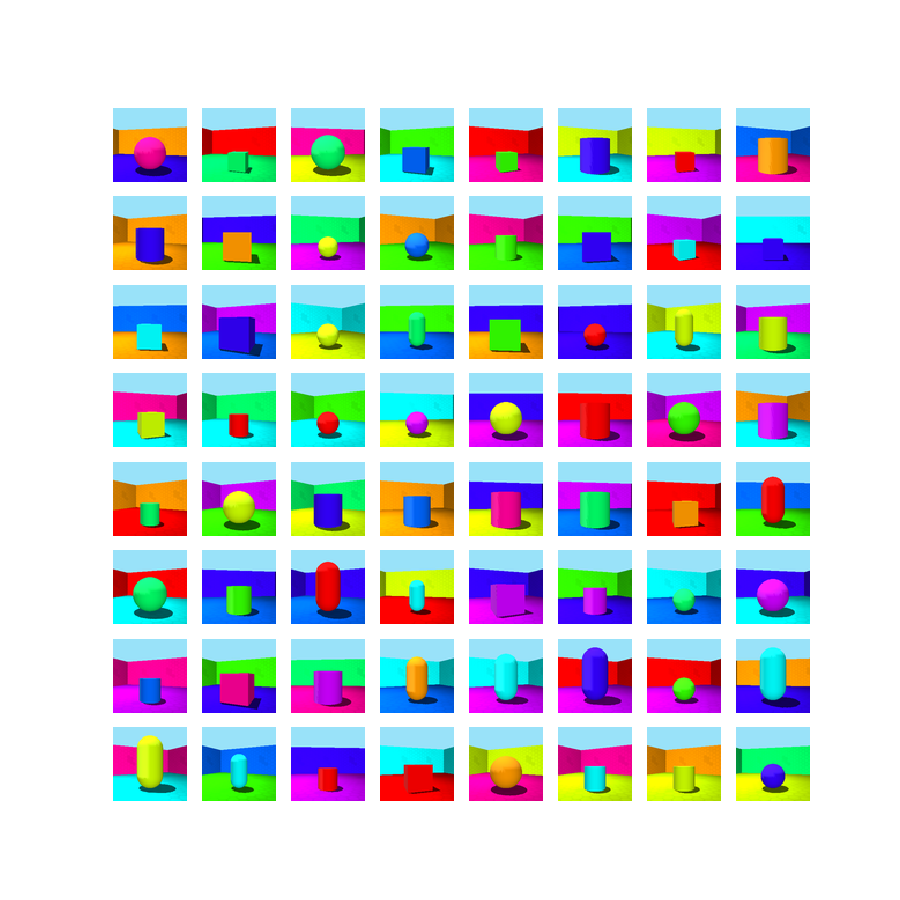

In [37]:
util.show_imgs(X[:64])
pass

In [38]:
# with torch.no_grad():
#     raw_Q = model.encode(X)
#     if isinstance(raw_Q, distrib.Distribution):
#         Q = raw_Q.mean
#     else:
#         Q = raw_Q
#     rec = model.decode(raw_Q)
# Q.shape, rec.shape

In [39]:
def _loss(r):
    r.loss = r[info.results_name]['stats']['rec_loss']['avg']
runs.map(_loss)
def _fid(r):
    r.fid = r[info.results_name]['rec_fid']
runs.map(_fid)
pass

In [40]:
l = list(runs.select('loss'))
lossrg = max(l)-min(l)
l = list(runs.select('fid'))
fidrg = max(l)-min(l)
lossrg,fidrg

(76.93798828125, 61.83429055997249)

<IPython.core.display.Javascript object>


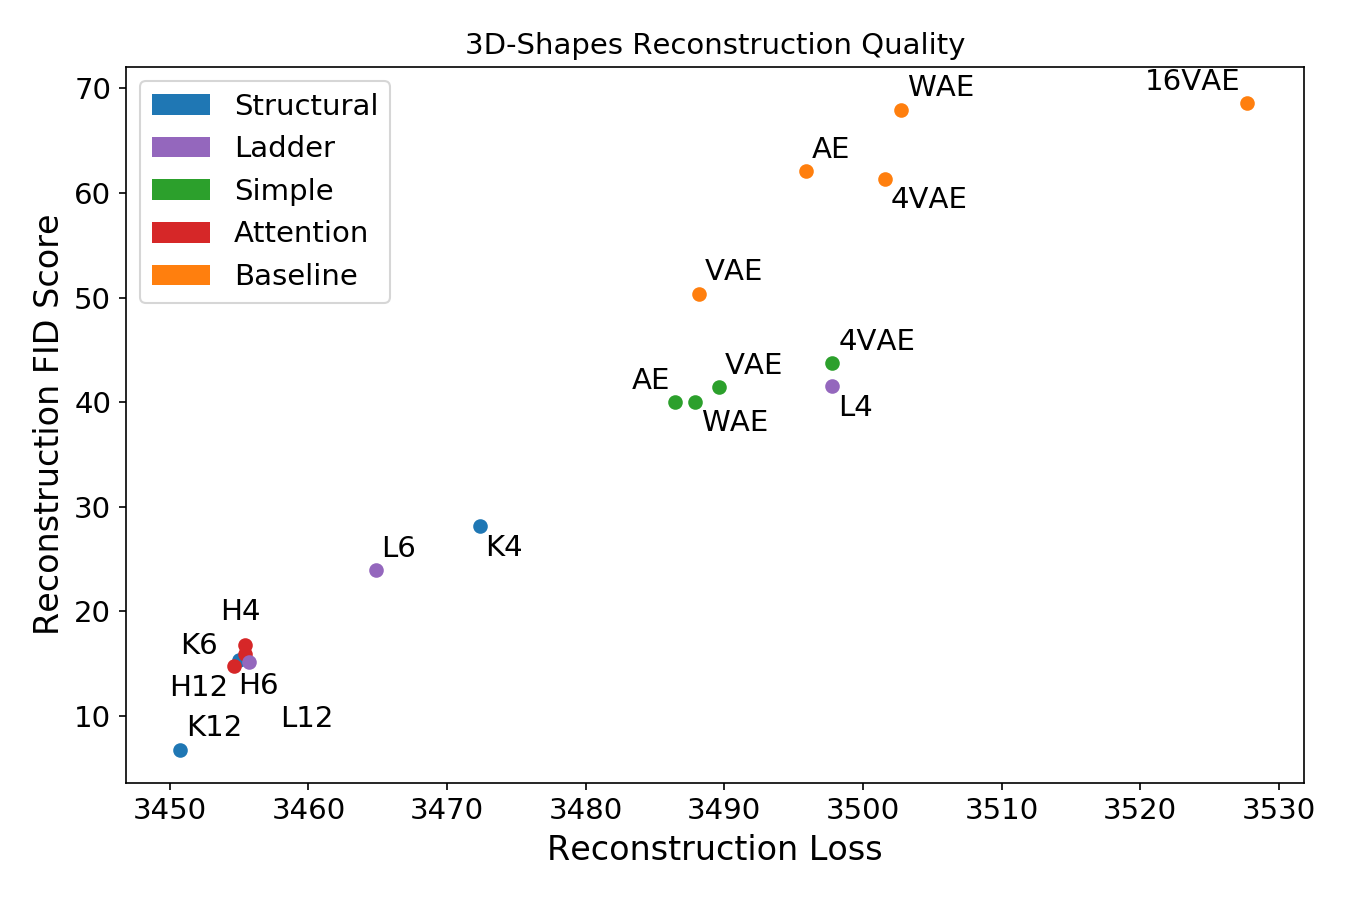

In [41]:
fig, ax = plt.subplots(figsize=info.fsize)
objs = []
texts = []
tps = set()
for r in runs:
    objs.append(plt.scatter(r.loss, r.fid, color=info.colors[r.arch]))
#     texts.append(plt.text(r.loss-(lossrg/10 if r.type == 'attn' else 0), r.fid, r.name))
    texts.append(plt.text(r.loss, r.fid, r.code, horizontalalignment='center',
      verticalalignment='center',))
    tps.add(r.arch)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))

legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in tps]
plt.legend(handles=legend_elements)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.xlim(left=6370)
# plt.ylim(bottom=0)
plt.tight_layout()
adjust_text(texts, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
            add_objects=objs,
           )
pass

In [42]:
save_fig(f'{info.ds}_{info.results_name}_perf_l')

3ds_final_perf_l saved


In [23]:
names, scores, typs = zip(*runs.selects('name', 'fid', 'arch'))
# names, scores, typs = zip(*runs.selects('name', 'loss', 'arch'))
names = np.array(names)
scores = np.array(scores)
typs = np.array(typs)
order = np.argsort(scores)
names = names[order]
scores = scores[order]
typs = typs[order]
clrs = [info.colors[t] for t in typs]
len(names), len(scores)

(19, 19)

<IPython.core.display.Javascript object>


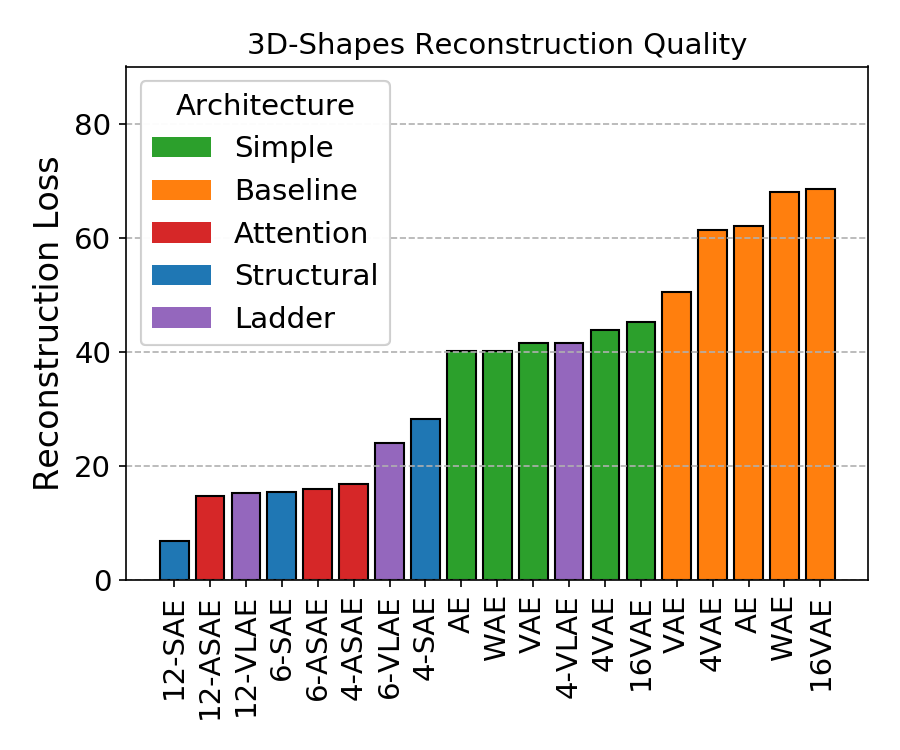

In [24]:
fig, ax = plt.subplots(figsize=(6,5))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c in zip(x,scores,clrs):
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend = plt.legend(handles=legend_elements, title='Architecture')
plt.ylabel('Reconstruction Loss')
# plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if info.ds == 'celeb':
    plt.ylim(80,130)
else:
    plt.ylim(0,90)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
pass

In [116]:
save_fig(f'{info.ds}_{info.results_name}_perf_bar_loss')

real_final_perf_bar_loss saved


In [25]:
runs[2].final.keys()

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid', 'prior_fid_stats', 'prior_fid'])

In [26]:
def _fid(r):
    r.gen = r[info.results_name]['hyb_fid']
    if 'prior_fid' in r[info.results_name]:
        r.prior = r[info.results_name]['prior_fid']
    elif 'prior_fid_stats' in r[info.results_name]:
        m,s = r[info.results_name]['prior_fid_stats']
        pm,ps = r[info.results_name]['gt_fid_stats']
        r.prior = fd.eval.fid.compute_frechet_distance(m,s,pm,ps)
        r[info.results_name]['prior_fid'] = r.prior
runs.map(_fid,pbar=tqdm)
pass

In [27]:
names, hybs, typs = zip(*runs.selects('name', 'gen', 'arch'))
try:
    pnames, priors, ptyps = zip(*runs.selects('name', 'prior', 'arch'))
except ValueError:
    pnames, priors, ptyps = (), (), ()
names = np.array(names + pnames)
scores = np.array(hybs + priors)
typs = np.array(typs + ptyps)
tps = np.array(['hyb']*len(hybs) + ['prior']*len(priors))
order = np.argsort(scores)
names = names[order]
scores = scores[order]
typs = typs[order]
tps = tps[order]
eclrs = [('xx' if t == 'hyb' else 'oo') for t in tps]
clrs = [info.colors[t] for t in typs]
len(names), len(scores)

(30, 30)

In [28]:
import matplotlib.lines as mlines

<IPython.core.display.Javascript object>


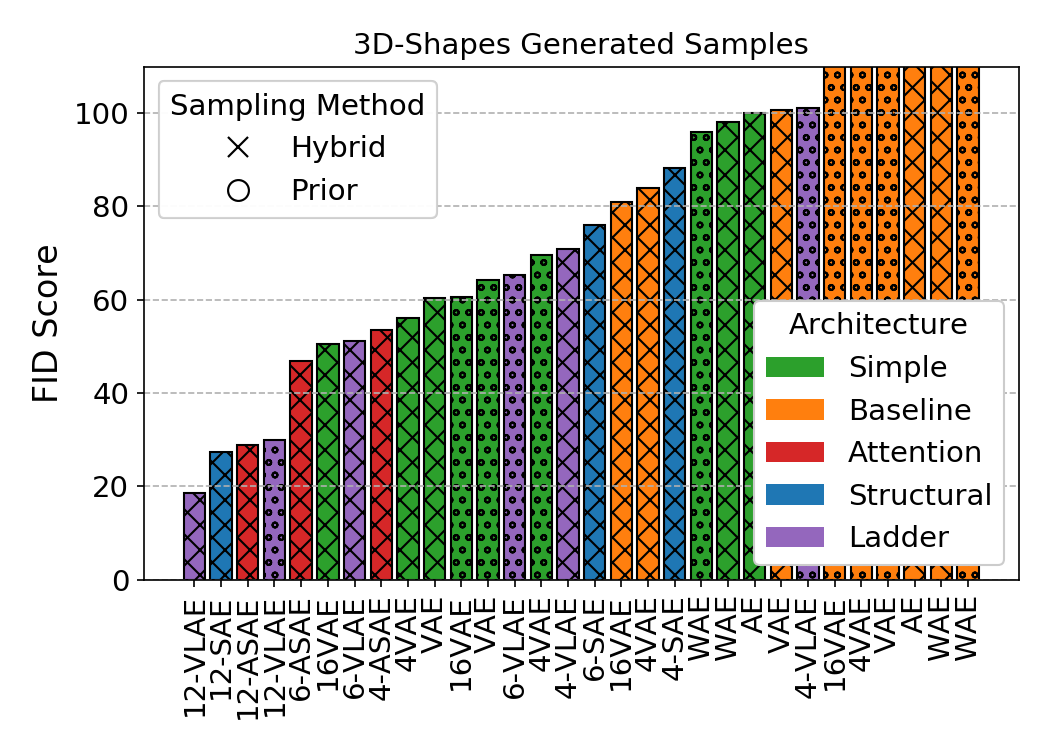

In [31]:
fig, ax = plt.subplots(figsize=(7,5))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Hybrid'), 
                    mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
                          markersize=10, label='Prior')]
legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
plt.ylim(0,110)
# plt.ylim(80,150)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
pass

In [122]:
save_fig(f'{info.ds}_{info.results_name}_gen_perf_new_l')

real_final_gen_perf_new_l saved


In [20]:
list(runs.selects('name', 'arch'))

[['AE', 'Conv'],
 ['VAE', 'Conv'],
 ['4VAE', 'Conv'],
 ['WAE', 'Conv'],
 ['12-SAE', 'Branch'],
 ['6-SAE', 'Branch'],
 ['4-SAE', 'Branch'],
 ['12-ASAE', 'Attention'],
 ['6-ASAE', 'Attention'],
 ['4-ASAE', 'Attention'],
 ['12-VLAE', 'Ladder'],
 ['6-VLAE', 'Ladder'],
 ['4-VLAE', 'Ladder']]

In [66]:
sel = runs.filter(lambda r: r.arch == 'Attention')
sel = runs.filter(lambda r: r.name == fixed_names['12 Branch'])
sel = runs.filter(lambda r: r.name == fixed_names['4 Branch'])
# sel = runs.filter(lambda r: r.name == 'AE')
# sel = runs.filter(lambda r: r.name == '16-SAE')
# sel = runs.filter(lambda r: r.name == '16VAE' and r.arch == 'Baseline')
# sel = runs.filter(lambda r: r.name == 'VAE' and r.arch == 'Conv')
print(list(sel.selects('name', 'arch')))
def _label_heads(r):
    if '12' in r.name:
        r.heads = 12
    elif '6' in r.name:
        r.heads = 6
    elif '4' in r.name:
        r.heads = 4
    elif info.ds == 'celeb':
        r.heads = 16
sel.map(_label_heads)
def _settings(r):
    if 'heads' in r:
        r.tH, r.tW = {12:(12,1), 6:(6,2), 4:(4,3), 16:(16,2)}[r.heads]
        r.widths = {12:[1,8], 6:[1,3], 4:[1,2.2], 16:(1,3)}[r.heads]
    else:
        r.tH, rtW = 12,1
sel.map(_settings)
list(sel.select('name'))

[['4-SAE', 'Branch']]


['4-SAE']

In [67]:
# sel.map(load_data, pbar=tqdm)
sel.map(load_model, pbar=tqdm)
pass

load successful
Loaded D:\completed\mpi3d-ae-real-4b3_0056-6468034-02_200525-033422\checkpoint_100000.pth.tar
Set dataroot to: D:\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 3 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
  factors: 2
  branches (type=iter) with 4 elements
  layers (type=iter) with 4 elements
  Creating branches[0] (type=norm-ada-in)
    sty

In [68]:
run = sel[0]
model = run.model
model.to(info.device)
run.name

'4-SAE'

In [69]:
# X = run[info.results_name]['out']['original']
with torch.no_grad():
    Q = model.encode(X.to(info.device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[info.bidx]
Q.shape, q.shape

(torch.Size([128, 12]), torch.Size([12]))

In [70]:
info.n = 16
info.steps = 20
info.steps = 7
# info.steps = 5
info.ntrav = 1
info.stretch = 0.1

In [71]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=info.steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-info.stretch*rg, Q.max(0)[0].unsqueeze(-1)+info.stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

torch.Size([1, 12, 7, 3, 64, 64])

In [72]:
if info.ds == 'celeb':
    run.tH, run.tW = 16, 2
    run.tH, run.tW = 32, 1
run.tH, run.tW = 4,3
run.tH, run.tW

(4, 3)

In [73]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, run.tH, run.tW, S, C, H, W)
# full = full.permute(0, 3, 4, 1, 5, 2, 6).contiguous().view(B, S, C, tH * H, tW * W)
full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

full.shape

torch.Size([4, 192, 448, 3])

In [74]:
def color_ax(c):
    ax.spines['bottom'].set_color(c)
    ax.spines['top'].set_color(c) 
    ax.spines['right'].set_color(c)
    ax.spines['left'].set_color(c)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.yaxis.label.set_color(c)
    ax.xaxis.label.set_color(c)
    ax.title.set_color(c)

In [75]:
cmap = cm.get_cmap('jet')

In [76]:
# highlight = [None]*12
# highlight = ['C1']*12

# highlight = [0,1,-1,2,3,-1,-1,4,-1,-1,-1,5]
# mh = max(info.highlight)
# hls = [(cmap(h/mh) if h >= 0 else 'k') for h in highlight]
# hls = [(f'C{h}' if h >= 0 else 'k') for h in info.highlight]
# len(hls), hls

<IPython.core.display.Javascript object>


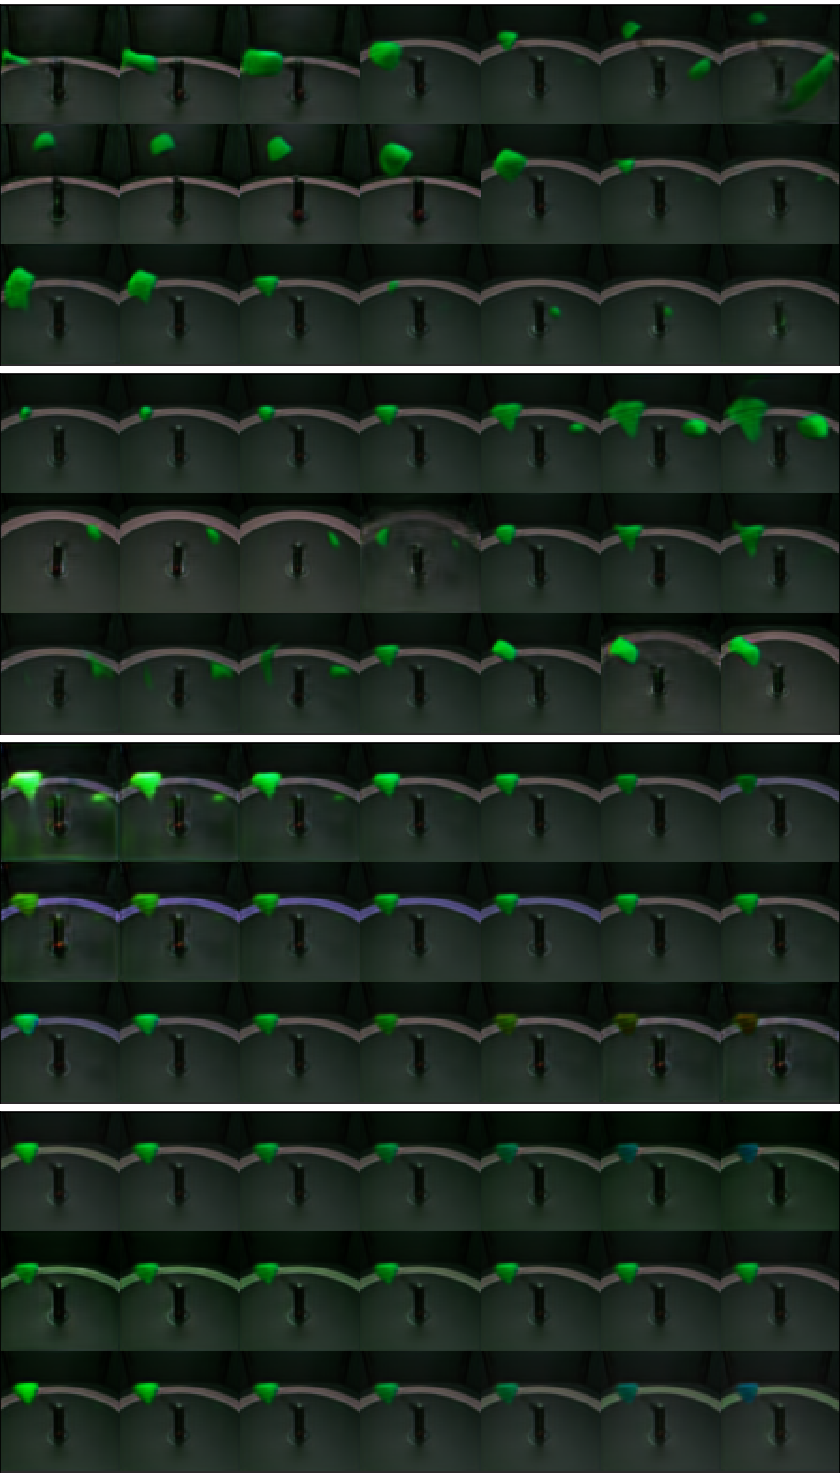

In [77]:
fig, axes = plt.subplots(run.tH,1, figsize=(info.steps*0.8,run.tH*run.tW*0.82))
for i,(ax, p) in enumerate(zip(axes,full)):
    plt.sca(ax)
    lw=3
#     ax.spines['bottom'].set_linewidth(lw)
#     ax.spines['top'].set_linewidth(lw) 
#     ax.spines['right'].set_linewidth(lw)
#     ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
border, between = 0.01, 0.02
border, between = 0.0, 0.0
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [78]:
save_fig(f'{info.ds}_{info.results_name}_order_4')

real_final_order_4 saved


In [95]:
# save_fig(f'{ds}_order')

In [96]:
# model#.enc.pointnet.tfms[2]

In [97]:
with torch.no_grad():
    model(X.to(info.device))

In [98]:
actv = model.enc.pointnet.tfms[2]._w.clone()
B, H,_,L = actv.shape
actv = actv.view(B,H,1,L)*100
actv.shape

torch.Size([128, 4, 1, 961])

In [99]:
single = actv[info.bidx]
avg = actv.mean(0)
single.shape, avg.shape

(torch.Size([4, 1, 961]), torch.Size([4, 1, 961]))

In [100]:
scolor = [1,0,0,]
acolor = [0,1,0]
scolor, acolor = torch.tensor(scolor).float(), torch.tensor(acolor).float()
scale = 5 if info.ds == 'celeb' else 2
scolor, acolor = scolor*scale, acolor*scale
scolor, acolor = scolor.view(1,3,1), acolor.view(1,3,1)
at = scolor*single + acolor*avg
print(at.max())
if info.ds == 'celeb':
    asize = (3,63,63)
else:
    asize = (3,31,31)

at = at.view(H,*asize).clamp(max=1)
at = at.permute(0,2,3,1).contiguous()
at.shape

tensor(24.3058)


torch.Size([4, 31, 31, 3])

<IPython.core.display.Javascript object>


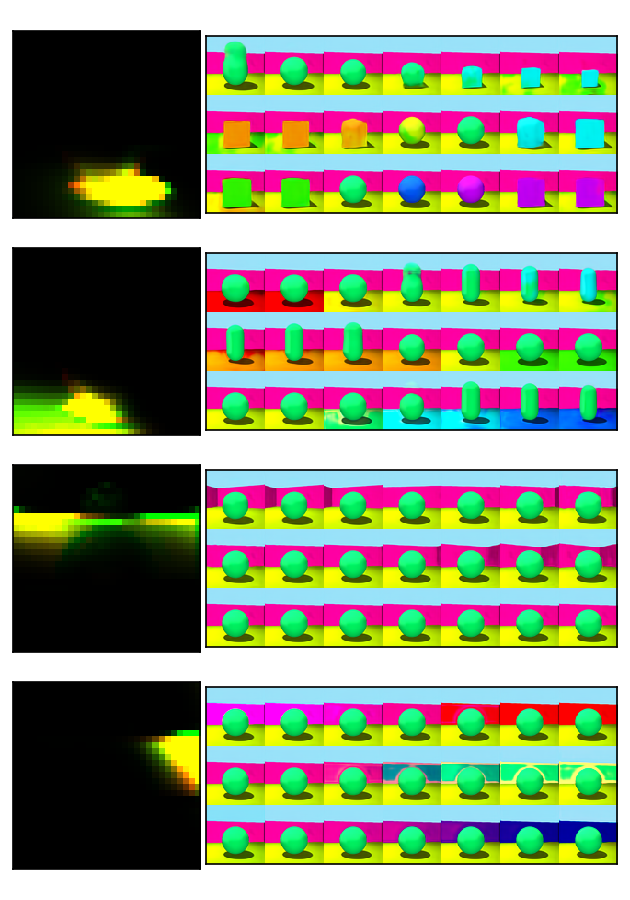

In [101]:

fig, axes = plt.subplots(run.tH,2, figsize=(5,18) if info.ds == 'celeb' else (4.2,6), #figsize=(5,6.8), 
                         
                         gridspec_kw={'width_ratios':run.widths})
for i,((ac,ax), p,a) in enumerate(zip(axes,full,at)):
    plt.sca(ax)
    lw=3
#     ax.spines['bottom'].set_linewidth(lw)
#     ax.spines['top'].set_linewidth(lw) 
#     ax.spines['right'].set_linewidth(lw)
#     ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
    
    plt.sca(ac)
    plt.imshow(a.numpy())
    plt.xticks([])
    plt.yticks([])
    
border, between = 0.02, 0.05
border, between = (0.0, 0.0) if info.ds == 'celeb' else (0.02,0.02)
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [102]:
save_fig(f'{info.ds}_attn_{run.heads}')

3ds_attn_4 saved


In [32]:
list(runs.selects('name', 'arch'))

[['AE', 'Conv'],
 ['VAE', 'Conv'],
 ['4VAE', 'Conv'],
 ['16VAE', 'Conv'],
 ['WAE', 'Conv'],
 ['12-SAE', 'Branch'],
 ['6-SAE', 'Branch'],
 ['4-SAE', 'Branch'],
 ['12-ASAE', 'Attention'],
 ['6-ASAE', 'Attention'],
 ['4-ASAE', 'Attention'],
 ['12-VLAE', 'Ladder'],
 ['6-VLAE', 'Ladder'],
 ['4-VLAE', 'Ladder'],
 ['AE', 'Baseline'],
 ['VAE', 'Baseline'],
 ['4VAE', 'Baseline'],
 ['16VAE', 'Baseline'],
 ['WAE', 'Baseline']]

In [127]:
gen_model_names = [
    ('AE', 'Conv'),
    ('VAE', 'Conv'),
    ('4VAE', 'Conv'),
    ('16VAE', 'Conv'),
    ('WAE', 'Conv'),
    (fixed_names['12 Branch'], 'Branch'),
#     ('6 Branch', 'Branch'),
#     ('4 Branch', 'Branch'),
    (fixed_names['12 Head'], 'Attention'),
#     ('6 Head', 'Attention'),
#     ('4 Head', 'Attention'),
#     ('4 LVAE', 'Ladder'),
#     ('6 LVAE', 'Ladder'),
    (fixed_names['12 LVAE'], 'Ladder'),
#     ('AE', 'Baseline'),
    ('VAE', 'Baseline'),
    ('4VAE', 'Baseline'),
#     ('16VAE', 'Baseline'),
#     ('WAE', 'Baseline'),
    ('16-SAE', 'Branch'),
    ('16-ASAE', 'Attention'),
]
len(gen_model_names)

12

In [128]:
gen = runs.filter(lambda r: (r.name, r.arch) in gen_model_names)
gen.sort_by('name')
len(gen), list(gen.selects('name', 'arch'))

(10,
 [['12-ASAE', 'Attention'],
  ['12-SAE', 'Branch'],
  ['12-VLAE', 'Ladder'],
  ['16VAE', 'Conv'],
  ['4VAE', 'Conv'],
  ['4VAE', 'Baseline'],
  ['AE', 'Conv'],
  ['VAE', 'Conv'],
  ['VAE', 'Baseline'],
  ['WAE', 'Conv']])

In [134]:
gen[1].sgen = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], '3ds-ae-12b1_0052-6286534-00_200429-030431', 'adv_gen.pth.tar'))

In [130]:
# def _results(r):
#     path = os.path.join(os.environ['FOUNDATION_SAVE_DIR'], r.rname)
# #     r.results = torch.load(os.path.join(path, 'results.pth.tar'))
# #     r.out = r.results['out']
#     if 'adv_gen.pth.tar' in os.listdir(path):
#         r.sgen = torch.load(os.path.join(path, 'adv_gen.pth.tar'))
# runs.map(_results, pbar=tqdm)
# pass

In [135]:
gen.map(load_model)
pass

In [136]:
from collections import OrderedDict

In [137]:
seqs = OrderedDict()
i= 20
N = 12

seqs['','Original', None] = X[i:i+N]

for run in gen:
    
    with torch.no_grad():
        g = run.model.generate_hybrid(N)
        seqs[run.name, 'hybrid', run.arch] = g
        
        try:
            gp = run.model.generate_prior(N)
            seqs[run.name, 'prior', run.arch] = gp
        except:
            gp = None
    
    if 'sgen' in run:
        seqs[run.name, 'strctrd', run.arch] = run.sgen['periodic_gen'][i:i+N].contiguous()


        
for n in seqs:
#     print(n)
    g = seqs[n].cpu()
    N,C,H,W = g.shape
    g = g.permute(2,0,3,1).contiguous().view(H,N*W,C)
    seqs[n] = g
        
seqs.keys()

odict_keys([('', 'Original', None), ('12-ASAE', 'hybrid', 'Attention'), ('12-SAE', 'hybrid', 'Branch'), ('12-SAE', 'strctrd', 'Branch'), ('12-VLAE', 'hybrid', 'Ladder'), ('12-VLAE', 'prior', 'Ladder'), ('16VAE', 'hybrid', 'Conv'), ('16VAE', 'prior', 'Conv'), ('4VAE', 'hybrid', 'Conv'), ('4VAE', 'prior', 'Conv'), ('4VAE', 'hybrid', 'Baseline'), ('4VAE', 'prior', 'Baseline'), ('AE', 'hybrid', 'Conv'), ('VAE', 'hybrid', 'Conv'), ('VAE', 'prior', 'Conv'), ('VAE', 'hybrid', 'Baseline'), ('VAE', 'prior', 'Baseline'), ('WAE', 'hybrid', 'Conv'), ('WAE', 'prior', 'Conv')])

<IPython.core.display.Javascript object>


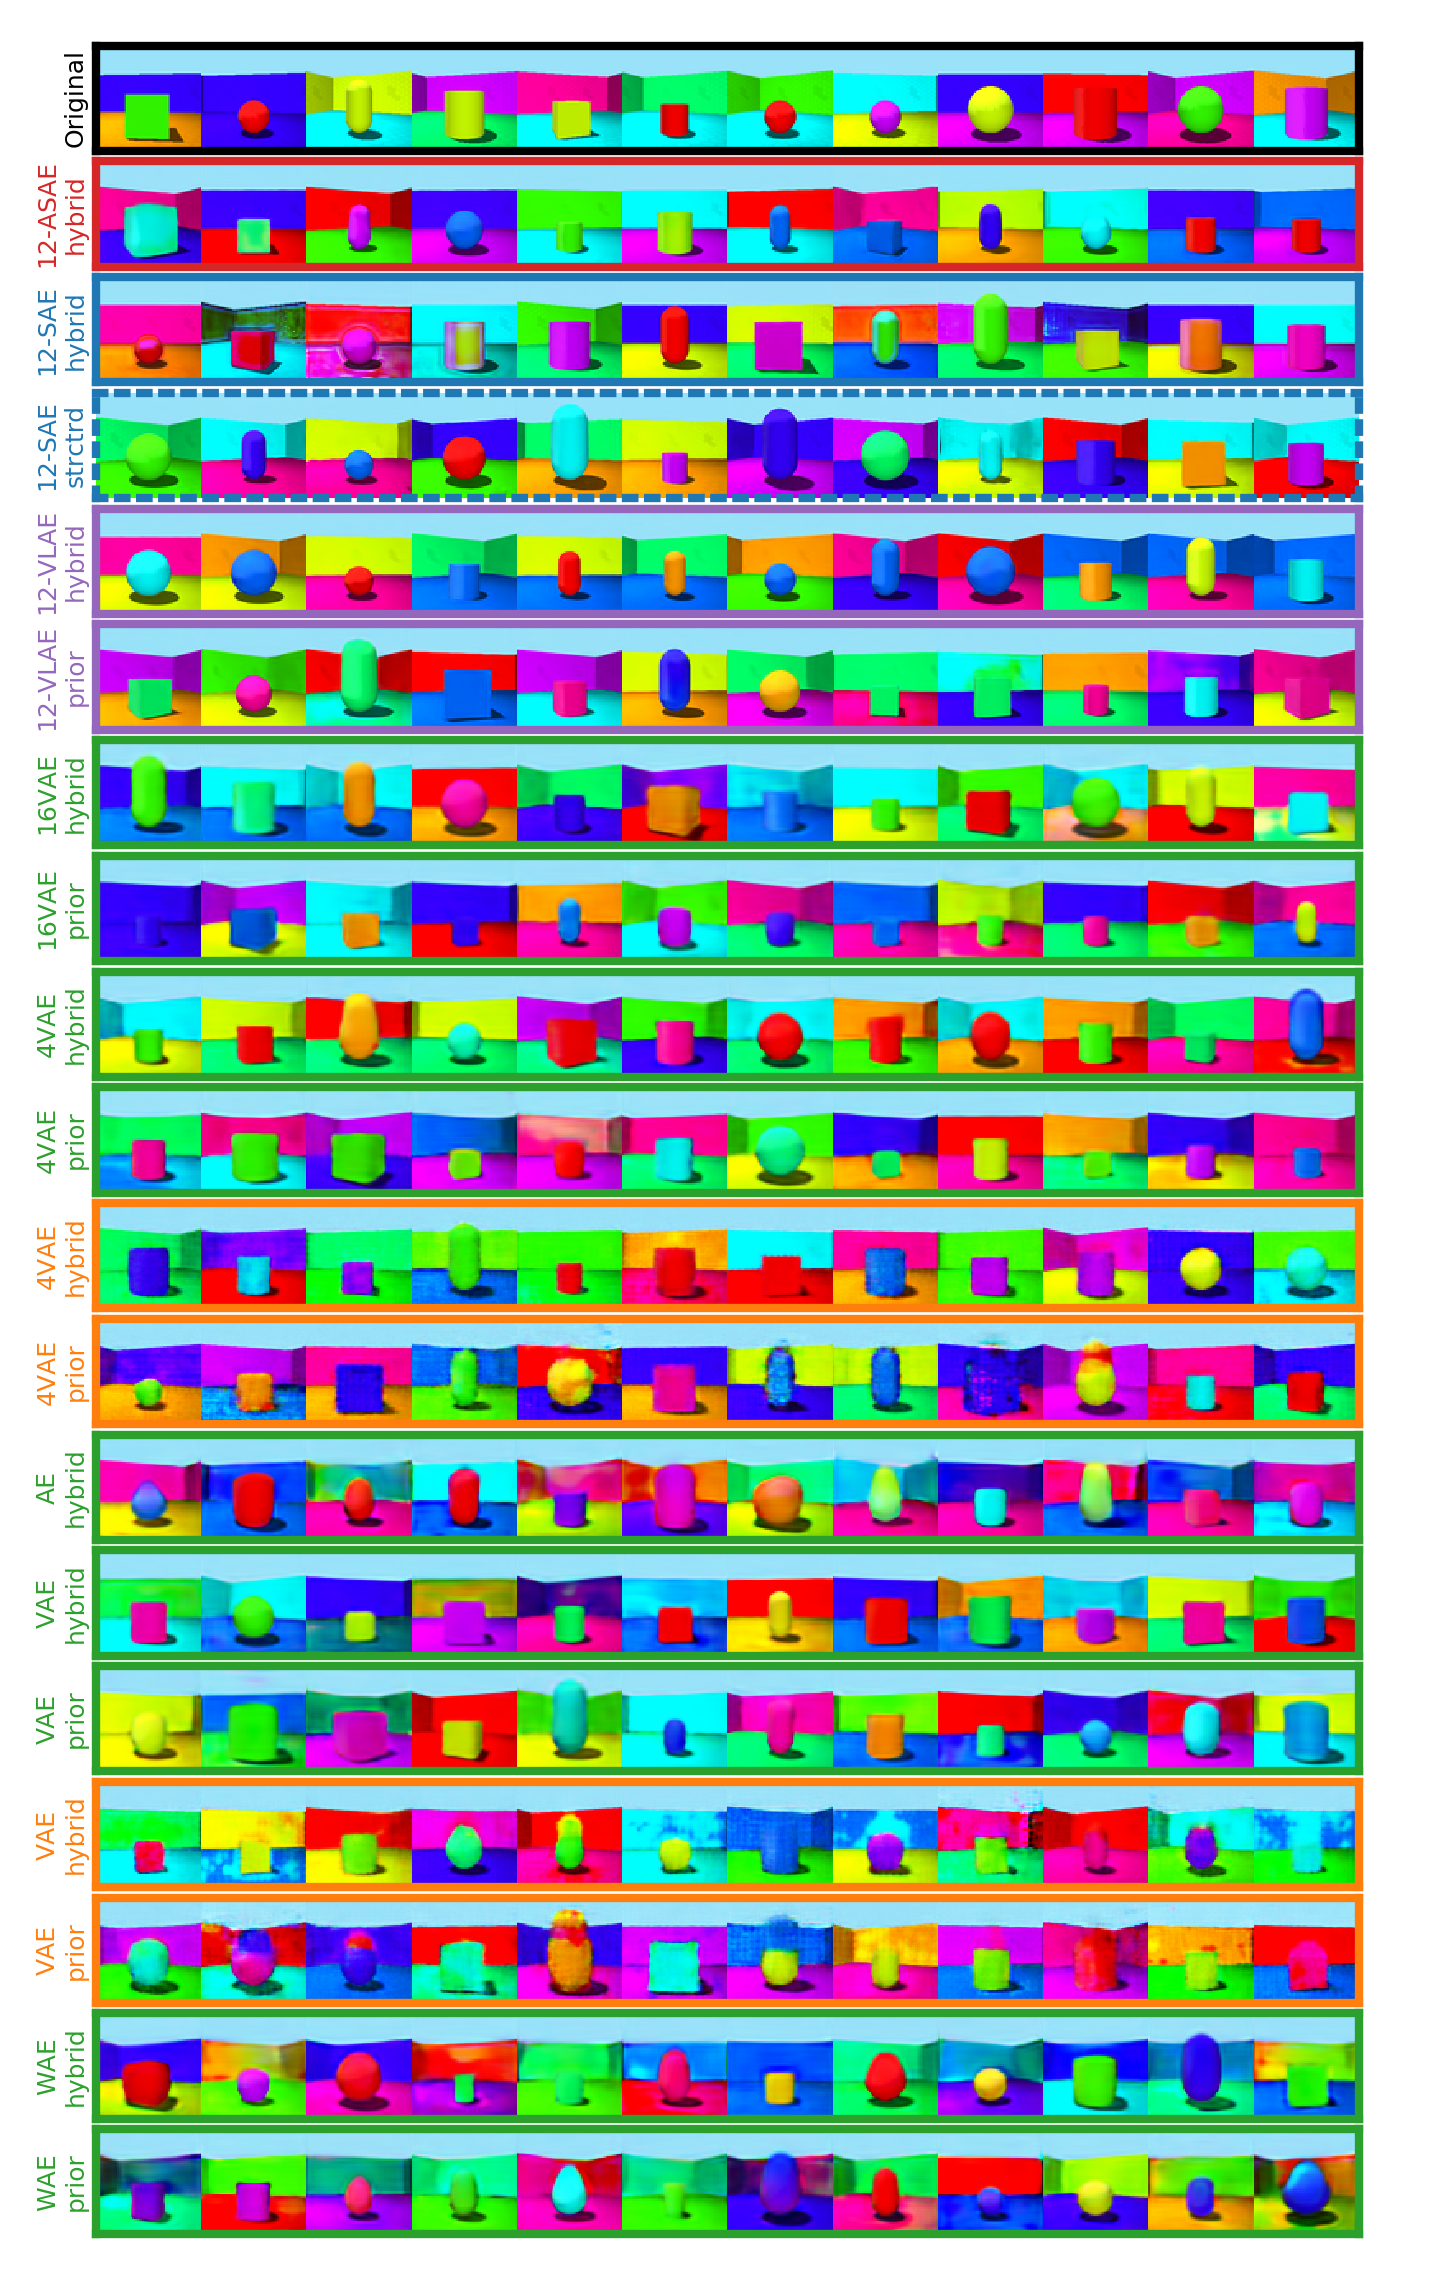

In [138]:
fig, axes = plt.subplots(len(seqs),1, figsize=(N*0.8,len(seqs)*0.80))

for i, (ax, ((n,t,a),g)) in enumerate(zip(axes, seqs.items())):
    
    plt.sca(ax)
    
    lw=4
    ax.spines['bottom'].set_linewidth(lw)
    ax.spines['top'].set_linewidth(lw) 
    ax.spines['right'].set_linewidth(lw)
    ax.spines['left'].set_linewidth(lw)
    if a in info.colors:
        color_ax(info.colors[a])
    if t == 'strctrd':
        ls = 'dotted'
#         ls = (0, (3,1,2,1))
        ax.spines['bottom'].set_linestyle(ls)
        ax.spines['top'].set_linestyle(ls) 
        ax.spines['right'].set_linestyle(ls)
        ax.spines['left'].set_linestyle(ls)
    plt.imshow(g.numpy())
    plt.ylabel(f'{n}\n{t}', fontsize=12)
#     if len(n):
#         plt.title(f'{n} ({t})')
#     else:
#         plt.title(f'{t}')
#     plt.ylabel(f'({t})')
    plt.xticks([])
    plt.yticks([])
border, between = 0.02, 0.08
border, between = 0.0, 0
plt.subplots_adjust(wspace=between, hspace=0.1,
                    left=0.01, right=1 - border, bottom=0.02, top=1 - 0.02)

In [139]:
save_fig(f'{info.ds}_gen')

3ds_gen saved
